In [1]:
import sys
sys.path.append('/Users/junran/Desktop/capstone_moonboard/data')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import seaborn as sns

In [2]:
from preprocessing import *
from helper import *

Number of routes after scraping: 30642
Number of routes after cleaning: 25099


In [3]:
samples = draw_samples(mb_2016, 25000)

In [4]:
sample_matrices = get_matrices(samples, ['start','mid','end'])[0]

In [5]:
print(len(sample_matrices))

25000


In [6]:
# reshaped
sample_vectors = {}
for i in sample_matrices:
    sample_vectors[i] = np.array(sample_matrices[i]).reshape(1, 198)

In [7]:
sample_grades = {}
for key in samples:
    sample_grades[key] = mb_2016[key]['grade']

In [8]:
sample_grades_list = list(sample_grades.values())
sample_vectors_list = list(sample_vectors.values())

sample_data = []

for i in range(len(sample_grades_list)):
    sample_data.append([])
    
    vector = sample_vectors_list[i][0]
    grade = sample_grades_list[i]
    for j in range(11*18):
        sample_data[i].append(vector[j])
    sample_data[i].append(grade)

In [9]:
sample_df = pd.DataFrame(sample_data)
sample_df.rename(columns = {198:'Grade'}, inplace = True)
sample_df

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,Grade
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
24996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
24997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
24998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
X = sample_df.iloc[:, :-1]
y = sample_df.iloc[:, -1]

In [12]:
y.unique()

array([3, 1, 0, 5, 6, 2, 4, 7, 8, 9])

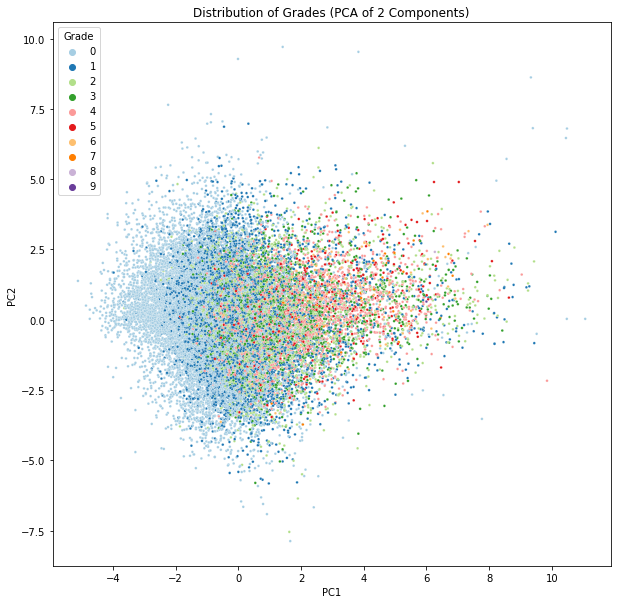

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)

plt.figure(figsize=(10,10))
#plot = plt.scatter(Xt[:,0], Xt[:,1], c=y, s=2, palette="Set2")
ax = sns.scatterplot(x=Xt[:,0], y=Xt[:,1], hue=y, palette="Paired", s = 7, legend="full")
ax.set(xlabel='PC1', ylabel='PC2', title = 'Distribution of Grades (PCA of 2 Components)')

#plt.legend(handles=plot.legend_elements()[0], labels=list(range(0,10)))
#plt.legend(custom, ['V4', 'V5', 'V6'], loc='lower right')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# define functions we need for cross validation and assessing model accuracy

def cross_val(model, k):
    """
    Perform kfold cross validation and print results.
    ---
    Inputs:
    - model: trained classification model
    - k: number of splits/iterations
    """
    # kfold cross validation with k splits
    cv = KFold(n_splits=k, random_state=1, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv)

    # scatterplot of cross validation scores and mean score
    x = range(k)
    plt.scatter(x, scores)
    plt.axhline(y=np.mean(scores), color = 'red')
    plt.title('k-fold cross validation results')
    plt.xlabel('CV iteration')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.1])
    print('\n')
    plt.show()
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

def metrics(actual, predicted):
    """
    Print classification report and confusion matrix for the results of a classification model.
    ---
    Inputs:
    - actual: list of actual y values
    - predicted: list of predicted y values
    """
    print("\nClassification report:\n" + classification_report(actual, predicted, zero_division = 0))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, predicted)
    ax = plt.axes()
    sns.heatmap(cm, annot=True, annot_kws={"size": 7}, fmt='d',cmap="Blues", ax = ax )
    ax.set_title('Confusion Matrix')
    plt.show()

Model: Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1816
           1       0.40      0.56      0.47      1388
           2       0.30      0.11      0.16       625
           3       0.23      0.10      0.14       436
           4       0.36      0.48      0.41       518
           5       0.26      0.08      0.12       155
           6       0.25      0.02      0.04        45
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         3

    accuracy                           0.50      5000
   macro avg       0.25      0.21      0.21      5000
weighted avg       0.48      0.50      0.48      5000


Confusion matrix:


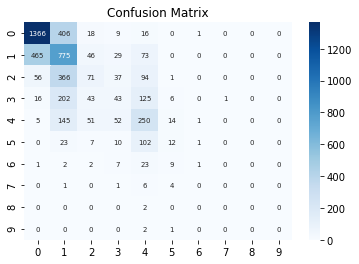

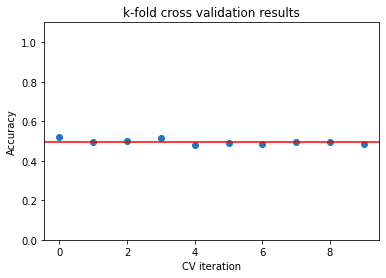

0.50 accuracy with a standard deviation of 0.01


In [16]:
# logistic regression classifier

log_classifier = LogisticRegression(random_state = 0, max_iter=3000)
log_classifier.fit(X_train, y_train)
log_predicted = log_classifier.predict(X_test)

print("Model: Logistic Regression")

# k = 37 (number of total images) for leave one out cross validation
#cross_val(log_classifier, len(images))
metrics(y_test, log_predicted)
cross_val(log_classifier, 10)

Model: Naive Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.74      0.64      1793
           1       0.42      0.22      0.29      1424
           2       0.19      0.07      0.10       655
           3       0.16      0.05      0.08       437
           4       0.19      0.03      0.05       471
           5       0.03      0.01      0.02       141
           6       0.03      0.25      0.05        57
           7       0.00      0.27      0.01        15
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         3

    accuracy                           0.35      5000
   macro avg       0.16      0.16      0.12      5000
weighted avg       0.38      0.35      0.34      5000


Confusion matrix:


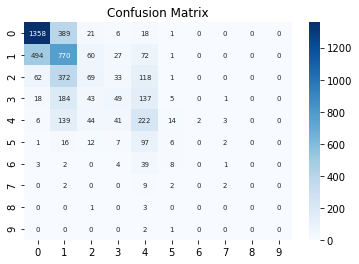

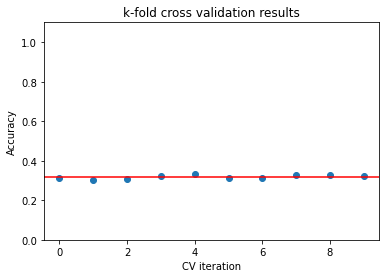

0.32 accuracy with a standard deviation of 0.01


In [18]:
# naive bayes

nb = GaussianNB()
nb_predicted = nb.fit(X_train, y_train).predict(X_test)

print("Model: Naive Bayes")
metrics(y_test, nb_predicted)
cross_val(nb, 10)

Model: Random Forest

Classification report:
              precision    recall  f1-score   support

           0       0.37      1.00      0.53      1793
           1       0.15      0.01      0.02      1424
           2       0.00      0.00      0.00       655
           3       0.00      0.00      0.00       437
           4       0.00      0.00      0.00       471
           5       0.00      0.00      0.00       141
           6       0.00      0.00      0.00        57
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         3

    accuracy                           0.36      5000
   macro avg       0.05      0.10      0.06      5000
weighted avg       0.17      0.36      0.20      5000


Confusion matrix:


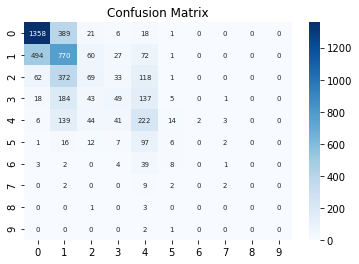

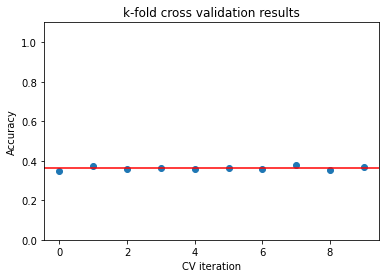

0.36 accuracy with a standard deviation of 0.01


In [21]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf_predicted = rf.fit(X_train, y_train).predict(X_test)

print("Model: Random Forest")
metrics(y_test, rf_predicted)
cross_val(rf, 10)

Model: XGBoost

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1793
           1       0.38      0.58      0.46      1424
           2       0.30      0.07      0.11       655
           3       0.38      0.09      0.14       437
           4       0.33      0.38      0.35       471
           5       0.25      0.07      0.11       141
           6       0.00      0.00      0.00        57
           7       0.25      0.13      0.17        15
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         3

    accuracy                           0.50      5000
   macro avg       0.26      0.21      0.21      5000
weighted avg       0.47      0.50      0.46      5000


Confusion matrix:


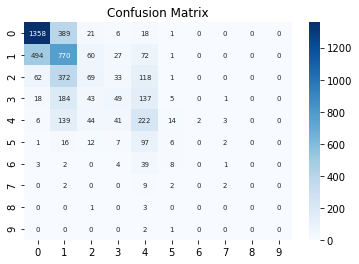

In [23]:
xgboost = HistGradientBoostingClassifier()
xgboost_predicted = xgboost.fit(X_train, y_train).predict(X_test)

print("Model: XGBoost")
metrics(y_test, xgboost_predicted)
#cross_val(xgboost, 10)